# 4. Restoration of the probability distribution function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm, gaussian_kde, entropy
from scipy.stats import entropy

Generate the data

In [3]:
np.random.seed(69420)
data1 = np.random.normal(loc=0, scale=1, size=500)
data2 = np.random.normal(loc=5, scale=0.5, size=500)
data = np.concatenate([data1, data2])

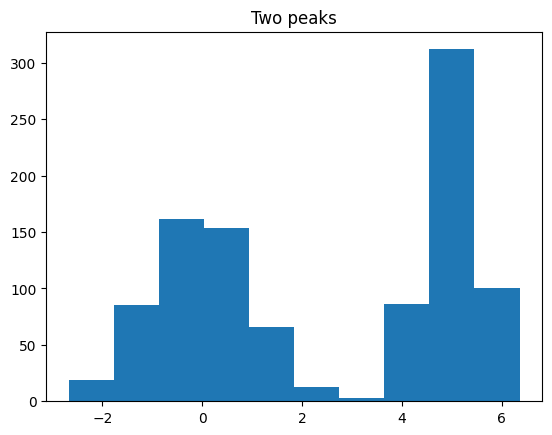

In [9]:
plt.hist(data)
plt.title('Two peaks')
plt.show()

In [116]:
class EM:
  def __init__(self, n_components):
    self.n_components = n_components

  def fit(self, X, n_steps=100):
    self.pi = np.ones((self.n_components)) / self.n_components
    self.means = np.random.choice(X, self.n_components)
    self.variances = np.random.random_sample(size=self.n_components)

    log_likelihood = 0
    for _ in range(n_steps):
      self._expectation_step(X)
      self._maximization_step(X)

      like = np.sum(np.log(np.sum(self.weights, axis=1)))
      if np.abs(like - log_likelihood) < 1e-3:
        break
      log_likelihood = like

  def _expectation_step(self, X):
    self.weights = np.zeros((self.n_components, len(X)))
    for j in range(self.n_components):
      self.weights[j, :] = norm(loc=self.means[j], scale=np.sqrt(self.variances[j])).pdf(X)
    return self.weights

  def _maximization_step(self, X):
    r = []
    for j in range(self.n_components):
      r.append((self.weights[j] * self.pi[j]) /
               (np.sum([self.weights[i] * self.pi[i]
                        for i in range(self.n_components)], axis=0)))
      self.means[j] = np.sum(r[j] * X) / (np.sum(r[j]))
      self.variances[j] = np.sum(r[j] * np.square(X - self.means[j])) / (np.sum(r[j]))
      self.pi[j] = np.mean(r[j])

  def score_samples(self, x):
    pdf = np.zeros(len(x))
    for k in range(self.n_components):
      pdf += norm.pdf(x, self.means[k], self.variances[k])
    return np.log(pdf)

def em_algorithm(data, x, n_components):
  em = GaussianMixture(n_components=n_components, random_state=1337)
  em.fit(data.reshape(-1, 1))
  return np.exp(em.score_samples(x.reshape(-1, 1)))

In [138]:
class KDE: # Is there a patch of KDE4 for FreeBSD, yet?
  def __init__(self, smoothness, kernel):
    self.kernel = kernel
    self.smoothness = smoothness

  def score_samples(self, x, data):
    n = len(data)
    density = np.zeros_like(x)

    for i, xi in enumerate(x):
      k_values = self.kernel((xi - data) / self.smoothness)
      density[i] = np.sum(k_values) / (n * self.smoothness)

    return density

SkLearn EM-algorithm via Gaussian Mixture Model

In [93]:
x = np.linspace(data.min(), data.max(), 1000)
em_probability = em_algorithm(data, x, 2)

My snappy EM implementation :^)

In [119]:
custom_em = EM(2)
custom_em.fit(data, n_steps=100)
custom_em_samples = custom_em.score_samples(x)
custom_em_probability = np.exp(custom_em_samples)

SciPy KDE implementation

In [106]:
kde_probability = gaussian_kde(data)(x)

My cool KDE implementation :3c

In [143]:
gaussian_kernel = lambda x: (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x ** 2)
custom_kde = KDE(0.1, gaussian_kernel)
custom_kde_probability = custom_kde.score_samples(x, data)

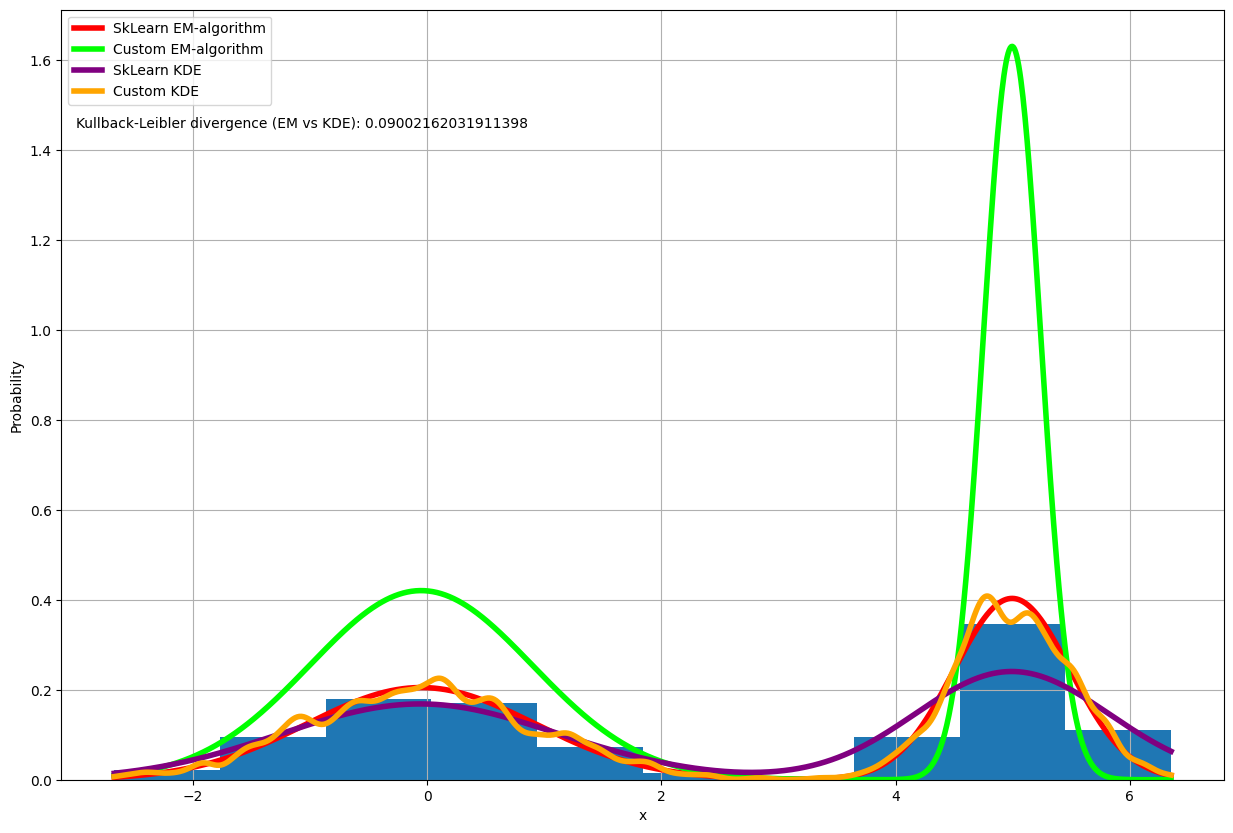

In [145]:
plt.figure(figsize=(15, 10))
plt.hist(data, density=True)
plt.plot(x, em_probability, color='r', linewidth=4, label='SkLearn EM-algorithm')
plt.plot(x, custom_em_probability, color='lime', linewidth=4, label='Custom EM-algorithm')
plt.plot(x, kde_probability, color='purple', linewidth=4, label='SkLearn KDE')
plt.plot(x, custom_kde_probability, color='orange', linewidth=4, label='Custom KDE')
plt.text(-3, 1.45, f'Kullback-Leibler divergence (EM vs KDE): {entropy(em_probability, kde_probability)}')
plt.grid()
plt.xlabel('x')
plt.ylabel('Probability')
plt.legend()
plt.show()

Metropolis-Hastings sampler

In [165]:
def metropolis_hastings(data, pdf, n_samples=1000, std=1.0):
    samples = []
    x = np.random.uniform(data[0], data[-1])
    pdf_func = lambda xi: np.interp(xi, data, pdf, left=0, right=0)

    for _ in range(n_samples):
        x_new = np.random.normal(x, std)
        acceptance_ratio = pdf_func(x_new) / (pdf_func(x) + 1e-9)
        if np.random.rand() < acceptance_ratio:
            x = x_new
        samples.append(x)

    return np.array(samples)

Gibbs sampler

In [150]:
def gibbs(data, n_steps=1000):
  samples = np.zeros(n_steps)
  for i in range(1, n_steps):
    # Uses uniform distribution by default
    x = np.random.choice([*data[:i], *data[i+1:]])
    samples[i] = x
  return np.array(samples)

In [166]:
meha_data_em = metropolis_hastings(x, em_probability)
meha_data_kde = metropolis_hastings(x, kde_probability)
gibbs_data = gibbs(data)

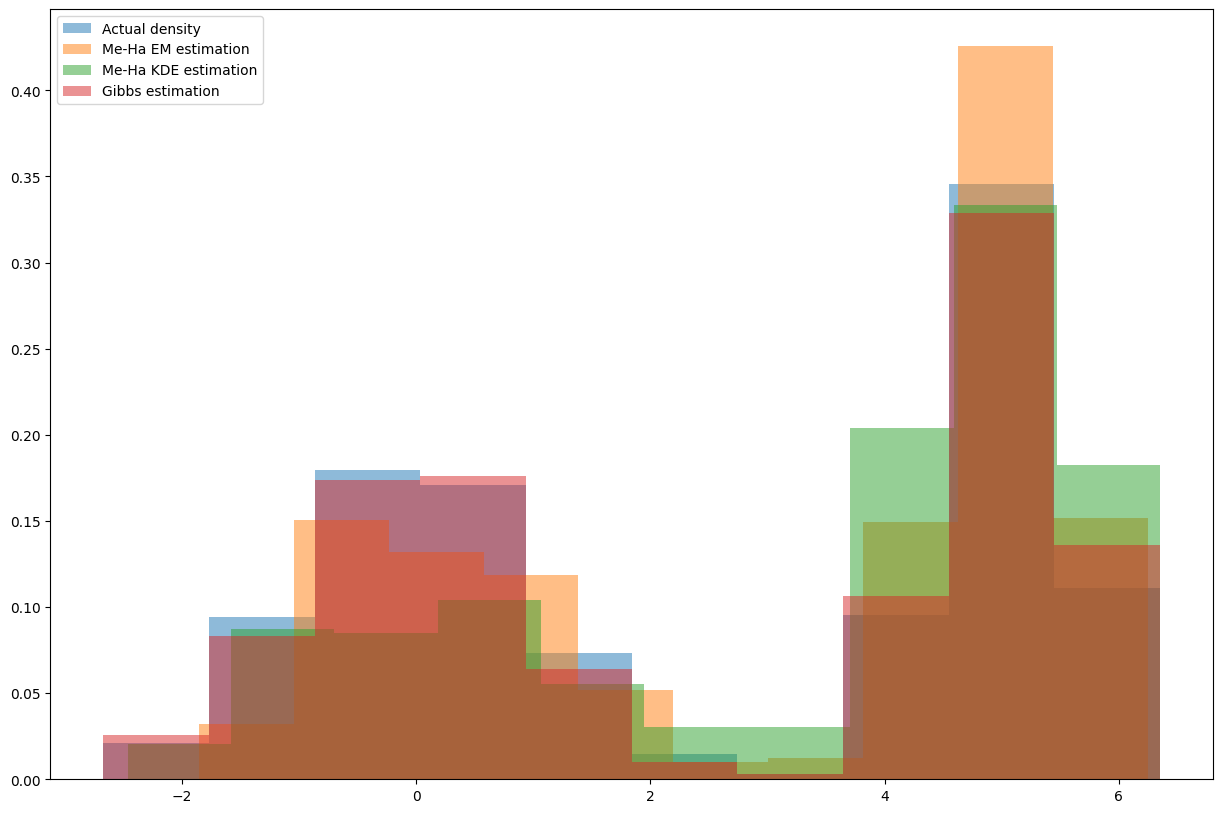

In [167]:
plt.figure(figsize=(15, 10))
plt.hist(data, density=True, alpha=0.5, label='Actual density')
plt.hist(meha_data_em, density=True, alpha=0.5, label='Me-Ha EM estimation')
plt.hist(meha_data_kde, density=True, alpha=0.5, label='Me-Ha KDE estimation')
plt.hist(gibbs_data, density=True, alpha=0.5, label='Gibbs estimation')
plt.legend()
plt.show()